### Imports (requiring github login) and plot utils

In [1]:
!pip -q install -r requirements.txt
!pip -q install .

In [2]:
import jax.numpy as np
from jax import random
from jax import vmap

import functools

from bayesian_ntk.utils import get_toy_data
from bayesian_ntk.models import homoscedastic_model
from bayesian_ntk.train import train_model
from bayesian_ntk.predict import Gaussian
from bayesian_ntk import predict, config, train_utils

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt

In [3]:
def format_plot(x=None, y=None):
    ax = plt.gca()
    if x is not None:
        plt.xlabel(x, fontsize=20)
    if y is not None:
        plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
    plt.gcf().set_size_inches(
        shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
        shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
    plt.tight_layout()
    
def plot_fn(train, test, *fs):
    train_xs, train_ys = train

    plt.plot(train_xs, train_ys, 'go', markersize=7, label='train')

    if test != None:
        test_xs, test_ys = test
        plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$y=x\mathrm{sin}(x)$')

        for f in fs:
            plt.plot(test_xs, f(test_xs), '-', linewidth=3)
    plt.xlim([-6., 6.])
    plt.ylim([-6., 6.])
    format_plot('$x$', '$y$')
    plt.legend()

# Toy 1d example notebook

The purpose of this notebook will be to demonstrate how to train Bayesian Deep Ensembles as described in our NeurIPS 2020 submission 'Bayesian Deep Ensembles via the Neural Tangent Kernel', using our provided package: `bayesian-ntk`. We will do this by going through the toy homoscedastic regression example from the submission: . The package builds on top of the [Neural Tangents](https://github.com/google/neural-tangents) library in [JAX](https://github.com/google/jax).

The package stores default config files in `bayesian_ntk.config`. For example, our default NN baselearner models will have the following config:


In [4]:
model_config = config.get_model_config('default')
print(model_config)

{'W_std': 1.5, 'b_std': 0.05, 'width': 512, 'depth': 2, 'activation': 'erf'}


We can now use Neural Tangents to return a `kernel_fn` function that calculates the analytic NTK & NNGP kernels for an infinite width version of the NN corresponding to our `model_config` under NTK parameterisation.

In [5]:
_, _, kernel_fn = homoscedastic_model(parameterization = 'ntk', **model_config)

Next we generate our training and test data, using the same `key` as in the paper for reproducibility. Note that `get_toy_data` returns noisy version of the train targets, in line with Lemma 3 of [Osband et al](https://papers.nips.cc/paper/8080-randomized-prior-functions-for-deep-reinforcement-learning).

In [7]:
key = random.PRNGKey(10);
data_config = config.get_data_config('default')
train_data, test_data = get_toy_data(key, config.NOISE_SCALE, **data_config);

Let's visualise our train and test data

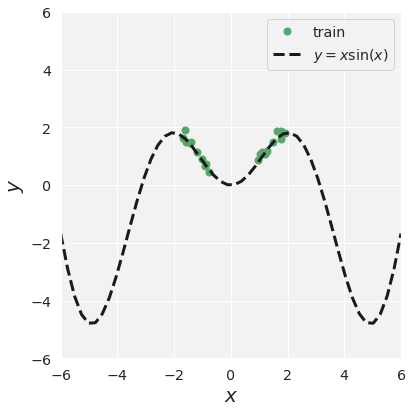

In [8]:
plot_fn(train_data, test_data)
finalize_plot((1,1))

## Making predictions 

We now proceed to calculate analytic GP posterior predictives with either NNGP/NTK as prior kernel. `bayesian_ntk.predict` is a stripped down version of [`neural_tangents.predict`](https://github.com/google/neural-tangents/blob/master/neural_tangents/predict.py) that does this, with a few differences to the original version: including functionality to calculate the NTKGP posterior, as well as ability to model observation noise. Of course we won't be able to use this for larger datasets, but for our toy example we can calculate the analytic NTKGP and NNGP posteriors (with observation noise), which we shall show below, storing results in a dictionary called `predictions`:

In [10]:
analytic_ntkgp_moments, analytic_nngp_moments = predict.gp_inference(
    kernel_fn = kernel_fn,
    x_train = train_data.inputs,
    y_train = train_data.targets,
    x_test = test_data.inputs,
    get = ('ntk', 'nngp'),
    diag_reg = config.NOISE_SCALE**2,
    compute_cov = True
);

predictions = {
    'NTKGP analytic': analytic_ntkgp_moments,
    'NNGP analytic': analytic_nngp_moments
};

We now compare these analytic GP posteriors to trained ensembles from each ensemble `train_method`: deep ensemble, randomised prior parameter (RP-param) and our NTKGP-param. We will use the `vmap` function in JAX to parallelise the baselearner training function `train_model` into one ensemble training function `train_ensemble`. 

The modified forward passes and different regularisation functions for each ensemble `train_method` can be found in `bayesian_ntk.train_utils`, and are called within `train_model`. 

We aggregate ensemble predictions and store them in `predictions`, like we did for the analytic posteriors.

In [11]:
train_config = config.get_train_config('default')
ensemble_key = random.split(key, config.ENSEMBLE_SIZE)
train_baselearner = lambda key, train_method: train_model(key, train_method, train_data, test_data, parameterization = 'standard', **train_config)
train_ensemble = lambda train_method: vmap(train_baselearner, (0, None))(ensemble_key, train_method)

In [ ]:
ensemble_methods_list = ['Deep ensemble', 'RP-param', 'NTKGP-param']

# this may take a few minutes
for method_idx, method in enumerate(ensemble_methods_list):
    method_input_str = train_utils.method_input_dct[method]
    print(f"Training ensemble method {method_idx+1}/{len(ensemble_methods_list)}: {method}")
    baselearners_test_pred = train_ensemble(method_input_str)
    ensemble_mean = np.mean(baselearners_test_pred, axis = 0).reshape(-1,)
    ensemble_var = np.var(baselearners_test_pred, axis = 0, ddof = 1).reshape(-1,)
    ensemble_std = np.sqrt(ensemble_var + config.NOISE_SCALE ** 2)
    predictions.update(
        {
            method: Gaussian(ensemble_mean, ensemble_std)
        }
    )

Training ensemble method 1/3: Deep ensemble


Finally, we plot mean predictions and 95% predictive CI for the different analytic posterior and ensemble methods, reproducing Figure 1 from our paper.

In [ ]:
#@title ##### (PLOT CODE)
plot_method_list = ['NNGP analytic'] + ensemble_methods_list
legend = functools.partial(plt.legend, fontsize=8.5)
for plt_idx in range(1, 5):
    plt.subplot(2, 2, plt_idx)
    plot_fn(train_data, test_data)
    
    ntkgp_moments = predictions['NTKGP analytic']
    ntkgp_means = ntkgp_moments.mean
    ntkgp_stds = ntkgp_moments.standard_deviation
    plt.plot(test_data.inputs, ntkgp_means, 'r-', linewidth = 3, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        ntkgp_means - 2 * ntkgp_stds,
        ntkgp_means + 2 * ntkgp_stds,
        color='r',
        alpha = 0.3
    )
    
    method = plot_method_list[plt_idx - 1]
    method_moments = predictions[method]
    method_means = method_moments.mean
    method_stds = method_moments.standard_deviation
    plt.plot(test_data.inputs, method_means, 'b-', linewidth = 2, alpha = 0.5)
    plt.fill_between(
        np.reshape(test_data.inputs, (-1,)),
        method_means - 2 * method_stds,
        method_means + 2 * method_stds,
        color='b',
        alpha = 0.3
    )
    
    legend(['Train', 'Test', 'NTKGP analytic', method], loc = 'upper left')
    plt.xlim([-6., 6.])
    plt.ylim([-6., 6.])
    format_plot('$x$', '$f$')
finalize_plot((2,2))